In [71]:
import numpy as np
import os
os.chdir('/Users/Sinead/DC-project/cleancode')
import core
import pylab as plt
import nibabel as nib
from skimage import filters
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import grey_dilation as gd
import time
from skimage.segmentation import find_boundaries as boundaries
import skimage
import SimpleITK as sitk

In [72]:
reload(core)

<module 'core' from 'core.pyc'>

In [36]:
import nipype.interfaces.fsl as fsl

def extract(thresholded):
    img = nib.Nifti1Image(thresholded, np.eye(4))
    nib.save(img, 'temp.nii.gz')
    img = nib.load('temp.nii.gz')
    mybet = fsl.BET()
    result = mybet.run(in_file='temp.nii.gz', out_file='BET-temp.nii.gz', frac=0.1)
    img = nib.load('BET-temp.nii.gz')
    data = img.get_data()
    return data

In [61]:
info = []
planes = np.load('/Volumes/SINEADUSB/Scans/planes-params.npy')

In [62]:
paths = ['/Volumes/SINEADUSB/Scans/ScanB/1.3.12.2.1107.5.1.4.51967.30000014110308064564000003547.dcm', 
        '/Volumes/SINEADUSB/DC-Project-Images/original/Sample2/S2_Post-op.nrrd',
        '/Volumes/SINEADUSB/Scans/ScanD/1.3.12.2.1107.5.1.4.95198.30000015040208110913600035431.dcm',
        '/Volumes/SINEADUSB/Scans/ScanE/1.3.12.2.1107.5.1.4.95198.30000015040208110913600035427.dcm',
        '/Volumes/SINEADUSB/Scans/ScanF/1.3.12.2.1107.5.1.4.95198.30000015061008243097400047435.dcm',
        '/Volumes/SINEADUSB/Scans/ScanG/1.3.12.2.1107.5.1.4.95198.30000015051507521609300034665.dcm',
        '/Volumes/SINEADUSB/Scans/ScanH/1.3.12.2.1107.5.1.4.95198.30000015072708211605400036461.dcm',
        '/Volumes/SINEADUSB/Scans/ScanI/1.3.12.2.1107.5.1.4.95198.30000015071109310409300075672.dcm',
        '/Volumes/SINEADUSB/Scans/ScanJ/1.2.392.200036.9116.2.6.1.48.1221600807.1432222434.802585.dcm']

In [73]:
for pathnumber in range(len(paths)):
    path = paths[pathnumber]
    print 'iteration number', pathnumber

    if path.endswith('.nii') or path.endswith('.nii.gz'):
        array, ConstPixelSpacing, affine = core.nifti2np(path)
        bone = core.thresholdnp(array, 1100, 1500)
        softtissue  = core.thresholdnp(array, 0, 80)

    elif path.endswith('.dcm'):
        array, ConstPixelSpacing, origin, path = core.dicom2np(path)
        bone = core.thresholdnp(array, 900, 1500)
        softtissue  = core.thresholdnp(array, 0, 80)

    elif path.endswith('.nrrd'):
        array, ConstPixelSpacing, affine = core.nrrd2np(path)
    #     array=np.swapaxes(array, 1, 2)
        bone = core.thresholdnp(array, 1100, 1500)
        softtissue  = core.thresholdnp(array, 0, 80)

    # skin

    skin_mask = array

    skin_mask = np.multiply(skin_mask, (array>-200).astype(int))
    array1 = np.multiply(skin_mask, (skin_mask>0.0).astype(int))
    array1 = np.multiply(array1, (array1>-200).astype(int))

    # skull

    skull_mask = array1>84.0
    array2 = np.multiply(array1, (array1<84.0).astype(int))

    # orbital

    orbital_mask = skull_mask

    for i in range(5):
        orbital_mask = bd(skull_mask)

    array3 = np.multiply(array2, (orbital_mask==False).astype(int))

    # cerebral ventricle
    array4 = np.multiply(array3, (array3>0.0).astype(int))

    # BET FSL
    array5 = extract(array4)
    brain_mask = np.multiply(bc(bfh(bd(array5))).astype(int), array5)

    # get ventricles
    ventr_mask1 = np.multiply((brain_mask>0).astype(int), (brain_mask<22).astype(int))
    ventr_mask2 = bd(ventr_mask1)
    ventr_mask3 = be(ventr_mask2)
    ventr_mask4 = bd(ventr_mask3)

    import skimage

    ventr_loop = ventr_mask3

    for i in range(4):
        labels = skimage.measure.label(ventr_loop, connectivity=3)
        props = skimage.measure.regionprops(labels)
        v = [p.area for p in props]
        ind = v.index(max(v))
        vcoords = props[ind].coords
        ventr_loop = np.zeros((array.shape))
        for i in range(len(vcoords)):
            a,b,c = vcoords[i]
            ventr_loop[a,b,c]=1
        ventr_loop = bd(be(ventr_loop))
        
    labels = skimage.measure.label(ventr_loop, connectivity=1)
    props = skimage.measure.regionprops(labels)
    v = [p.area for p in props]
    ind = v.index(max(v))
    vcoords = props[ind].coords
    ventr_loop = np.zeros((array.shape))
    for i in range(len(vcoords)):
        a,b,c = vcoords[i]
        ventr_loop[a,b,c]=1
    ventr_loop = bd(be(ventr_loop))

    v_mask = bfh(ventr_loop)
    
    mask = v_mask.astype(np.float64)
    mask = np.swapaxes(mask, 0, 1)
    mask = np.swapaxes(mask, 0, 2)
    
    img = sitk.GetImageFromArray(mask)
    sampleimg = sitk.ReadImage(path)
    img.SetDirection(sampleimg.GetDirection())
    if not path.endswith('.dcm'):
        origin = sampleimg.GetOrigin()
    img.SetOrigin(origin)
    img.SetSpacing(ConstPixelSpacing)
    midplaneMaskPath = os.path.join(os.path.split(path)[0], 'vmaskbatch.mha')
    sitk.WriteImage(img, midplaneMaskPath)

    # get haematoma

    h_mask = (array5>50.0).astype(float)*1000
    array6 = np.multiply(brain_mask, h_mask)
    array7 = be(array6)
    array8 = bc((array7))
    array9 = bfh((array8))
    array10 = bd(bd((array8)))
    array11 = bfh(bd(array10))
    import skimage

    h_loop = array11

    for i in range(4):
        labels = skimage.measure.label(h_loop, connectivity=3)
        props = skimage.measure.regionprops(labels)
        h = [p.area for p in props]
        ind = h.index(max(h))
        hcoords = props[ind].coords
        h_loop = np.zeros((array.shape))
        for i in range(len(hcoords)):
            a,b,c = hcoords[i]
            h_loop[a,b,c]=1
        h_loop = bd(be(h_loop))
        
    labels = skimage.measure.label(h_loop, connectivity=1)
    props = skimage.measure.regionprops(labels)
    h = [p.area for p in props]
    ind = h.index(max(h))
    hcoords = props[ind].coords
    h_loop = np.zeros((array.shape))
    for i in range(len(hcoords)):
        a,b,c = hcoords[i]
        h_loop[a,b,c]=1
    h_loop = bd(be(h_loop))
    
    h_mask = bfh(h_loop)
    
    mask = h_mask.astype(np.float64)
    mask = np.swapaxes(mask, 0, 1)
    mask = np.swapaxes(mask, 0, 2)

    
    img = sitk.GetImageFromArray(mask)
    sampleimg = sitk.ReadImage(path)
    img.SetDirection(sampleimg.GetDirection())
    if not path.endswith('.dcm'):
        origin = sampleimg.GetOrigin()
    img.SetOrigin(origin)
    img.SetSpacing(ConstPixelSpacing)
    midplaneMaskPath = os.path.join(os.path.split(path)[0], 'hmaskbatch.mha')
    sitk.WriteImage(img, midplaneMaskPath)

    # volumes analysis
    plane = planes[pathnumber]
    a,b,c,d = plane[1:].astype(np.float64)

    shape = array.shape
    midplane_split = np.zeros(shape)
    for k in range(shape[2]):
        x = np.arange(0,shape[0],1)
        z = np.linspace(0,shape[2],shape[0])
        xx, yy = np.meshgrid(z, (d-c*z-a*x)/b)
        y = yy.astype(int)
        for j in range(len(y)):
            midplane_split[y[k,j]:shape[0],:, k]=1

    v_mask = (v_mask).astype(int)
    h_mask = (h_mask).astype(int)

    left_h = np.multiply(h_mask, midplane_split==0)
    right_h = np.multiply(h_mask, midplane_split==1)

    left_v = np.multiply(v_mask, midplane_split==0)
    right_v = np.multiply(v_mask, midplane_split==1)

    brain = np.multiply(brain_mask, (h_mask==0).astype(int)) # no haematoma

    left_brain = np.multiply(brain, midplane_split==0)
    right_brain = np.multiply(brain, midplane_split==1)

    # Ventricle Analysis
    brainArea = []
    for i in range(brain_mask.shape[2]):
        brainArea.append(np.count_nonzero(brain_mask[:,:,i]))
    midsliceIndex = np.argmax(brainArea)

    
    # check that there is ventricle at the midsliceIndex

    if (np.nonzero(v_mask[:,:,midsliceIndex]) == 0) != False:
        print 'using vArea for vcentroid'
        vArea = []
        for i in range(brain_mask.shape[2]):
            vArea.append(np.count_nonzero(v_mask[:,:,i]))
        midsliceIndex = np.argmax(vArea)

    i = midsliceIndex

    nonzeros = np.nonzero(np.nan_to_num(v_mask[:,:,i]))
    w2, w1 = np.mean(nonzeros[0]), np.mean(nonzeros[1])

    left_h_vol = (left_h[left_h!=0]).size*np.prod(ConstPixelSpacing)
    right_h_vol = (right_h[right_h!=0]).size*np.prod(ConstPixelSpacing)
    left_brain_vol = (left_brain[left_brain!=0]).size*np.prod(ConstPixelSpacing)
    right_brain_vol = (right_brain[right_brain!=0]).size*np.prod(ConstPixelSpacing)
    left_ventr_vol = (left_v[left_v!=0]).size*np.prod(ConstPixelSpacing)
    right_ventr_vol = (right_v[right_v!=0]).size*np.prod(ConstPixelSpacing)

    dirname = os.path.split(os.path.dirname(path))[1]
    
    info.append((dirname, 'w1 = {}'.format(w1), 'w2 = {}'.format(w2), 
                 'Volume of haematoma on LHS is {}'.format(left_h_vol),
                 'Volume of haematoma on RHS is {}'.format(right_h_vol),
                 'Volume of brain on LHS is {}'.format(left_brain_vol),
                 'Volume of brain on RHS is {}'.format(right_brain_vol),
                 'Volume of CSF in ventricles on LHS is {}'.format(left_ventr_vol),
                 'Volume of CSF in ventricles on RHS is {}'.format(right_ventr_vol)))

    print info[pathnumber]

iteration number 0


ValueError: need more than 3 values to unpack

In [57]:
(left_v[left_v!=0]).size*np.prod(ConstPixelSpacing)+(right_v[right_v!=0]).size*np.prod(ConstPixelSpacing)

3915.3176391601569

In [ ]:
v_loop

<IPython.core.display.Javascript object>


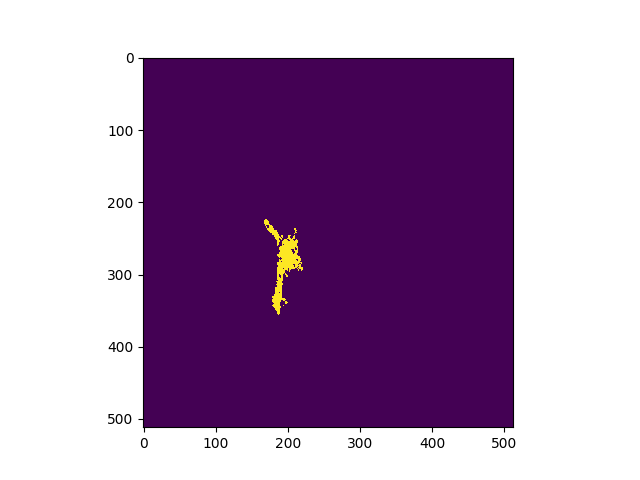

In [52]:
% matplotlib nbagg
plt.imshow(ventr_loop[:,:,159])
plt.show()
plt.ion()

In [ ]:
np.save('symmanalysisinfo.npy',info)

In [47]:
17.111 + 60

77.111

In [ ]:
# needs to be 3915